BoradBand detection with automatic noice detection

Teori:
Når man ser på amplituden til et signal og manulet estimerer hvor i signalet det kun er bakgrunnstøy, ser man etter et relativt flatt område med lav amplitude i forhold til resten av signalet.

Hyp: 
Om man kjører en hilbert transform av signalet og henter ut envelopen av signalet. der hvor envelopen har lav endring og lavest amplitude over tid bør være der hvor støyen i signalet ligger.

Signalet signal_med har blitt zero-padded under medfilt funksjonen. når programmet leter etter minste gjennomsnitts verdi for signalet, må hver ende av signalet kuttes. Ingen data som inkluderer en zero-padding kan inkluderes da disse er kuntig lave.

Hvor mye skal kuttes ned på hver side?
Disse linjene bestemmer hvor mye som skal midles:
    kernel_size = int(window_size*DS_Fs)+int(int(window_size*DS_Fs) % 2 == 0)
    signal_med = signal.medfilt(DS_Sx,kernel_size)
Dette fører til at verdiene fra [0:kernel_size] har inkludert zero-padding på venstre side, og [kernel_size:len(signal_med)-1] har inkludert padding på høyre.
Da vil alle valude data ligge på intervallet [kernel_size:-kernel_size]

noice = -30.750460624694824
noice = -43.10016632080078


/var/folders/zg/23sg06wj2kzb1l0qdkk5tr140000gn/T/ipykernel_95608/1434752177.py:88: RuntimeWarning: divide by zero encountered in log10
  signal_vals = 10*np.log10(signal_med/noice) - trigger


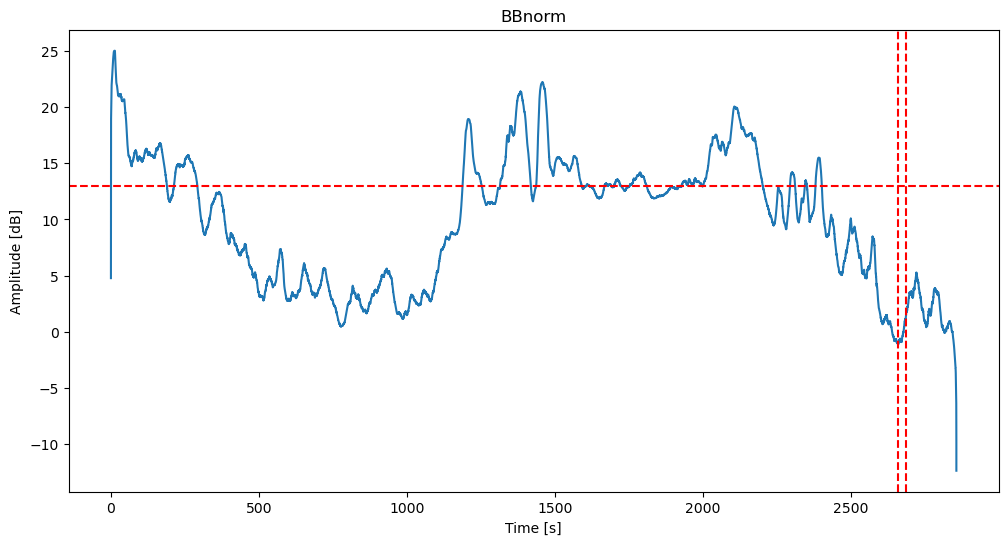

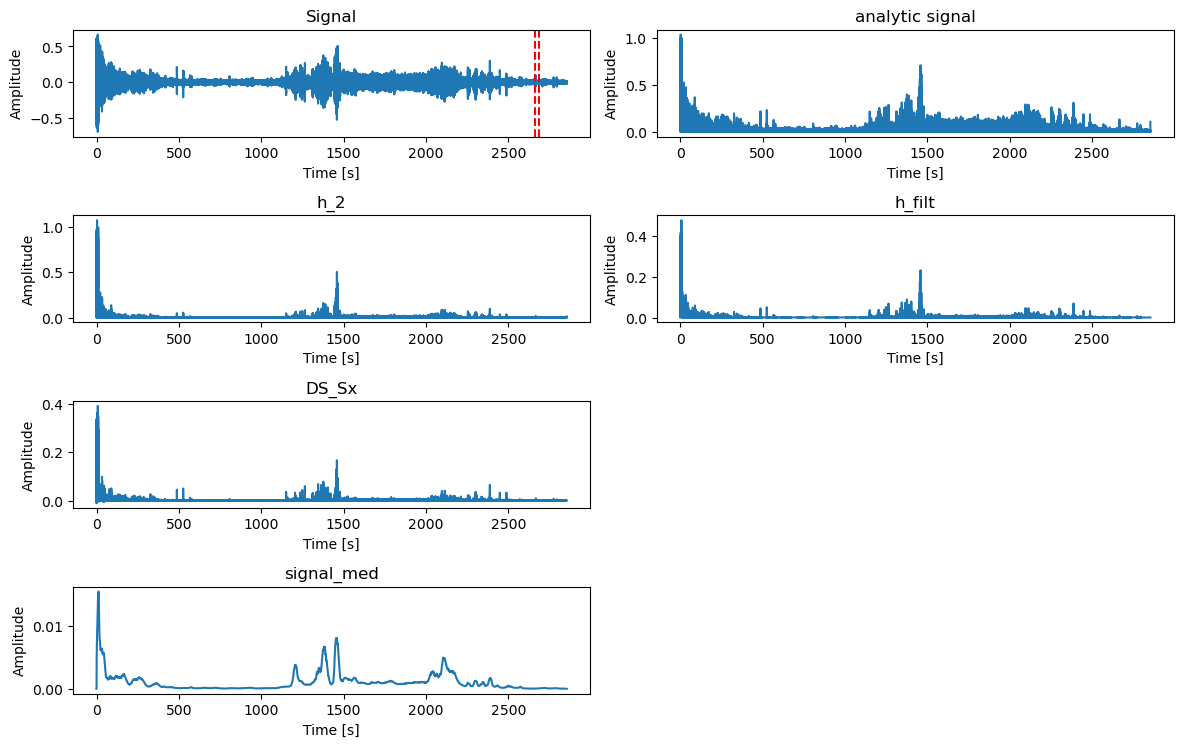

In [22]:
import librosa
import numpy as np
import scipy.signal as signal
from scipy.signal import resample_poly, hilbert
import matplotlib.pyplot as plt

#def BroadBand_from_file(input_file, Fds:int ,medfilt_window: int, window_size:int, noice_t_start:int, trigger:int, plot:bool):

#Parameters:

input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/2.wav"

Fds=3000
medfilt_window=15
window_size=20
noice_t_start=320
trigger=13
plot=True

#SOF

#Getting data from wav file
data_org, sr = librosa.load(input_file)
#data_org=data_org[int(600*sr):int(2e3*sr)]

window_size = int((len(data_org)/sr)*0.01)

#downsampling original audio data
data_offcet = resample_poly(data_org,1,int(sr/Fds))

#Removing Dc-offcet from data
dc_offcet = np.mean(data_offcet)
data = data_offcet - dc_offcet

#Hilbert transform ov data
analytic_signal = np.absolute(hilbert(data))
#Squaring each element
h_2 = np.square(analytic_signal)

#median filter
h_filt = signal.medfilt(h_2,medfilt_window)

#Downsampling
DS_Sx = resample_poly(h_filt,1,medfilt_window)
DS_Fs = Fds/medfilt_window
DS_t = np.linspace(0,(len(DS_Sx)/DS_Fs),len(DS_Sx))

# converting form seconds to samples
noice_t_start = int(noice_t_start*DS_Fs) 

noice_t_stop = int(noice_t_start+(window_size*DS_Fs))
noice = np.mean(DS_Sx[noice_t_start:noice_t_stop])
print(f"noice = {10*np.log10(noice)}")
DS_Fs = int(DS_Fs)

kernel_size = int(window_size*DS_Fs)+int(int(window_size*DS_Fs) % 2 == 0)
signal_med = signal.medfilt(DS_Sx,kernel_size)


#Auto noise detection
signal_med2 =signal_med[kernel_size:-kernel_size]
# Step 1: Identify groups of consecutive similar values
indices = np.arange(len(signal_med2))
groups = np.split(indices, np.where(np.diff(signal_med2) != 0)[0] + 1)

# Step 2: Compute the average amplitude for each group
group_averages = np.array([np.mean(signal_med2[g]) for g in groups])

# Step 3: Determine the lowest average and define a threshold
min_avg = np.min(group_averages)
threshold = min_avg * 1.5  # Allow small variations

# Step 4: Find the longest group within the threshold
valid_groups = [g for g, avg in zip(groups, group_averages) if avg <= threshold]
longest_group = max(valid_groups, key=len) if valid_groups else None

if longest_group is None or len(longest_group) == 0:
    middle_index= None  # No valid group found

# Step 5: Return the middle index of the selected group
middle_index = kernel_size +longest_group[len(longest_group) // 2]
noice_start = int(middle_index-(window_size*DS_Fs//2))
noice_stop = int(middle_index+(window_size*DS_Fs//2))
noice = np.mean(signal_med[noice_start:noice_stop])
print(f"noice = {10*np.log10(noice)}")


signal_vals = 10*np.log10(signal_med/noice) - trigger

try:
    indices = np.where(signal_vals > 0)[0]
    Trigger_time = indices/DS_Fs
except:
    Trigger_time = 0
    print("Warning: Trigger is too high")
    print("No trigger time registerd")

if plot ==True:
    BBnorm_t = np.linspace(0,(len(signal_vals)/DS_Fs),len(signal_vals))

    plt.figure(figsize=(12,6))

    plt.plot(BBnorm_t,signal_vals + trigger)
    plt.axhline(y=trigger, color='red', linestyle='--', label="Trigger")
    plt.axvline(x=noice_start/DS_Fs, color='red', linestyle='--')
    plt.axvline(x=noice_stop/DS_Fs, color='red', linestyle='--')
    plt.title("BBnorm")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [dB]")
    plt.show()


#Debug plotting


t = np.linspace(0,len(data)/Fds,len(data))

plt.figure(figsize=(12,9))
plt.subplot(5,2,1)
plt.plot(t,data)
plt.axvline(x=noice_start/DS_Fs, color='red', linestyle='--')
plt.axvline(x=noice_stop/DS_Fs, color='red', linestyle='--')
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")


plt.subplot(5,2,2)
plt.plot(t,analytic_signal)
plt.title("analytic signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")


plt.subplot(5,2,3)
plt.plot(t,h_2)
plt.title("h_2")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")


plt.subplot(5,2,4)
plt.plot(t,h_filt)
plt.title("h_filt")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")



plt.subplot(5,2,5)
plt.plot(DS_t,DS_Sx)
plt.title("DS_Sx")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")


plt.subplot(5,2,7)
plt.plot(DS_t,signal_med)
plt.title("signal_med")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")



plt.tight_layout()
plt.show()

    #return Trigger_time

Noise = -30.75038433074951 dB
Auto-detected noise = -43.10012340545654 dB


/var/folders/zg/23sg06wj2kzb1l0qdkk5tr140000gn/T/ipykernel_98368/3467322070.py:90: RuntimeWarning: divide by zero encountered in log10
  signal_vals = 10 * np.log10(signal_med / noice) - trigger


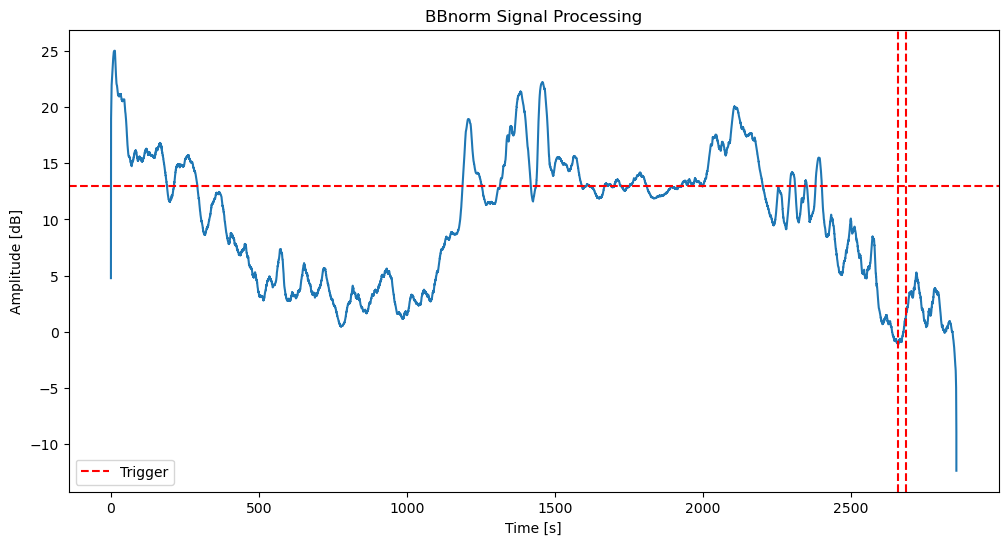

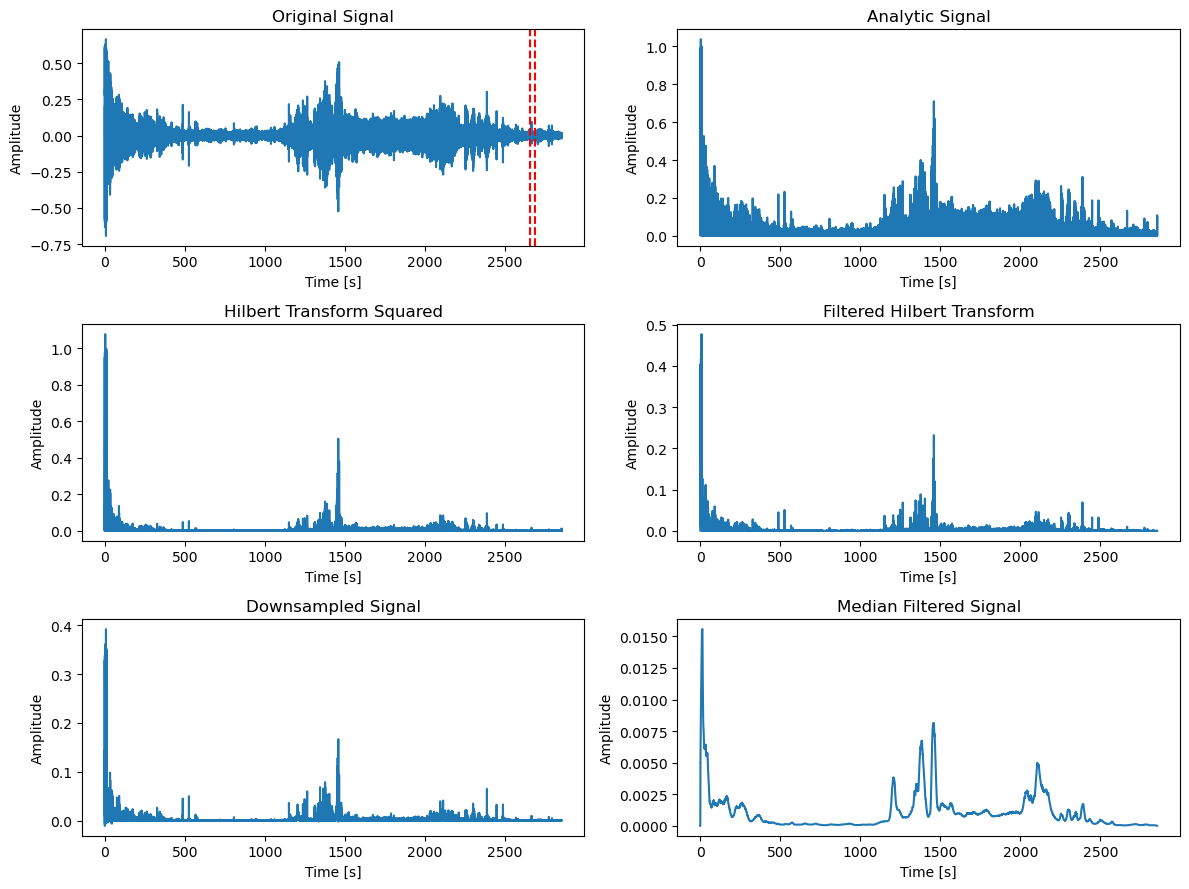

In [2]:
import librosa
import numpy as np
import scipy.signal as signal
from scipy.signal import resample_poly, hilbert
import matplotlib.pyplot as plt

# Parameters - User-defined settings
input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/2.wav"
Fds = 3000  # Target downsampling frequency
medfilt_window = 15  # Window size for median filtering
window_size = 20  # Window size for noise estimation (in seconds)
noice_t_start = 320  # Noise estimation start time (in seconds)
trigger = 13  # Detection threshold in dB
plot = True  # Toggle for plotting results

# Load audio file without resampling
# librosa.load automatically normalizes values between -1 and 1
# sr=None ensures the original sampling rate is used

data_org, sr = librosa.load(input_file, sr=None)  
window_size = int((len(data_org) / sr) * 0.01)  # Recalculate window size in samples

# Downsampling using polyphase filtering for better efficiency
# This reduces the sampling rate to Fds (from original sr)
data_offcet = resample_poly(data_org, 1, int(sr / Fds))

# Remove DC offset (mean value) to center the signal around zero
dc_offcet = np.mean(data_offcet)
data = data_offcet - dc_offcet

# Apply Hilbert transform to obtain the analytic signal
analytic_signal = np.abs(hilbert(data))

# Square the amplitude envelope to enhance energy variations
h_2 = analytic_signal**2

# Apply median filtering to remove short-term fluctuations
h_filt = signal.medfilt(h_2, medfilt_window)

# Downsample the filtered signal for further processing
DS_Sx = resample_poly(h_filt, 1, medfilt_window)
DS_Fs = Fds / medfilt_window  # Adjusted sampling frequency
DS_t = np.linspace(0, len(DS_Sx) / DS_Fs, len(DS_Sx))  # Time axis for plotting

# Convert noise start time from seconds to sample index
noice_t_start = int(noice_t_start * DS_Fs)
noice_t_stop = noice_t_start + int(window_size * DS_Fs)

# Estimate noise level based on a selected window
noice = np.mean(DS_Sx[noice_t_start:noice_t_stop])
print(f"Noise = {10 * np.log10(noice)} dB")

# Ensure kernel size is odd for median filtering
kernel_size = int(window_size * DS_Fs) | 1  # Ensures odd value

# Apply median filtering for noise reduction
signal_med = signal.medfilt(DS_Sx, kernel_size)

# Automatic noise detection
# Extract portion of the signal without the first and last kernel_size samples
signal_med2 = signal_med[kernel_size:-kernel_size]

# Identify groups of consecutive similar values using diff()
diff_indices = np.where(np.diff(signal_med2) != 0)[0] + 1

# Split indices into groups where values are similar
groups = np.split(np.arange(len(signal_med2)), diff_indices)

# Compute average amplitude for each group
group_averages = np.array([np.mean(signal_med2[g]) for g in groups])

# Define a threshold as 1.5 times the minimum average amplitude
threshold = np.min(group_averages) * 1.5

# Select the longest group within the threshold
valid_groups = [g for g, avg in zip(groups, group_averages) if avg <= threshold]
longest_group = max(valid_groups, key=len, default=None)

# If no valid group found, set middle index to None
if longest_group is None or len(longest_group) == 0:
    middle_index = None  # No valid group found
else:
    middle_index = kernel_size + longest_group[len(longest_group) // 2]
    noice_start = int(middle_index - (window_size * DS_Fs // 2))
    noice_stop = int(middle_index + (window_size * DS_Fs // 2))
    noice = np.mean(signal_med[noice_start:noice_stop])
    print(f"Auto-detected noise = {10 * np.log10(noice)} dB")

# Compute signal values relative to noise threshold
signal_vals = 10 * np.log10(signal_med / noice) - trigger

# Find indices where signal exceeds the threshold
indices = np.where(signal_vals > 0)[0]
Trigger_time = indices / DS_Fs if indices.size else 0

if indices.size == 0:
    print("Warning: Trigger too high, no trigger time registered")

# Plot the results if enabled
if plot:
    BBnorm_t = np.linspace(0, len(signal_vals) / DS_Fs, len(signal_vals))
    plt.figure(figsize=(12, 6))
    plt.plot(BBnorm_t, signal_vals + trigger)
    plt.axhline(y=trigger, color='red', linestyle='--', label="Trigger")
    plt.axvline(x=noice_start / DS_Fs, color='red', linestyle='--')
    plt.axvline(x=noice_stop / DS_Fs, color='red', linestyle='--')
    plt.title("BBnorm Signal Processing")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [dB]")
    plt.legend()
    plt.show()

    # Debugging plots
    t = np.linspace(0, len(data) / Fds, len(data))
    plt.figure(figsize=(12, 9))

    for i, (title, y) in enumerate(
        [
            ("Original Signal", data),
            ("Analytic Signal", analytic_signal),
            ("Hilbert Transform Squared", h_2),
            ("Filtered Hilbert Transform", h_filt),
            ("Downsampled Signal", DS_Sx),
            ("Median Filtered Signal", signal_med),
        ]
    ):
        plt.subplot(3, 2, i + 1)
        plt.plot(t if i <= 3 else DS_t, y)
        plt.title(title)
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        if i == 0:
            plt.axvline(x=noice_start / DS_Fs, color='red', linestyle='--')
            plt.axvline(x=noice_stop / DS_Fs, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()


Noise = -31.633548736572266 dB


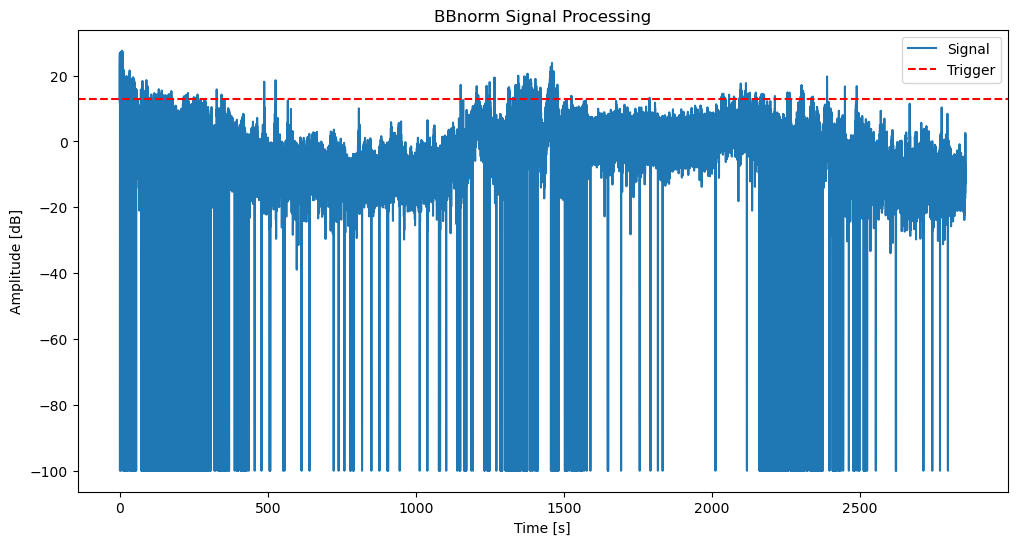

In [ ]:
import librosa
import numpy as np
import scipy.signal as signal
from scipy.signal import resample_poly, hilbert
import matplotlib.pyplot as plt

# Parameters
input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/2.wav"
Fds = 3000
medfilt_window = 15
window_size = 20
noice_t_start = 320
trigger = 13
plot = True

# Load audio data
data_org, sr = librosa.load(input_file, sr=None)
window_size_samples = int((len(data_org) / sr) * 0.01)

# Downsampling
data = resample_poly(data_org - np.mean(data_org), 1, sr // Fds)

# Hilbert transform and envelope calculation
h_2 = np.square(np.abs(hilbert(data)))

# Median filtering
h_filt = signal.medfilt(h_2, medfilt_window)

# Downsampling
DS_Sx = resample_poly(h_filt, 1, medfilt_window)
DS_Fs = Fds / medfilt_window

# Noise estimation
noice_t_start = int(noice_t_start * DS_Fs)
noice_t_stop = noice_t_start + int(window_size * DS_Fs)
noice = np.mean(DS_Sx[noice_t_start:noice_t_stop])
print(f"Noise = {10 * np.log10(noice)} dB")

# Median filtering for noise detection
kernel_size = int(window_size * DS_Fs) | 1  # Ensure odd size
signal_med = signal.medfilt(DS_Sx, kernel_size)

# Auto noise detection
signal_med2 = signal_med[kernel_size:-kernel_size]
groups = np.split(np.arange(len(signal_med2)), np.where(np.diff(signal_med2) != 0)[0] + 1)
group_averages = np.array([np.mean(signal_med2[g]) for g in groups])

threshold = np.min(group_averages) * 1.5
valid_groups = [g for g, avg in zip(groups, group_averages) if avg <= threshold]
longest_group = max(valid_groups, key=len, default=None)

if longest_group is not None:
    middle_index = kernel_size + longest_group[len(longest_group) // 2]
    noice_start = middle_index - (window_size * DS_Fs // 2)
    noice_stop = middle_index + (window_size * DS_Fs // 2)
    noice = np.mean(signal_med[noice_start:noice_stop])
    print(f"Auto-detected Noise = {10 * np.log10(noice)} dB")
else:
    noice_start = noice_stop = None
    print("No valid noise segment detected.")

# Signal normalization and thresholding
signal_vals = 10 * np.log10(signal_med / noice) - trigger

indices = np.where(signal_vals > 0)[0]
Trigger_time = indices / DS_Fs if indices.size > 0 else []
if not indices.size:
    print("Warning: Trigger is too high, no trigger time registered")

# Plot results
if plot:
    BBnorm_t = np.arange(len(signal_vals)) / DS_Fs
    plt.figure(figsize=(12, 6))
    plt.plot(BBnorm_t, signal_vals + trigger)
    plt.axhline(y=trigger, color='red', linestyle='--', label="Trigger")
    if noice_start and noice_stop:
        plt.axvline(x=noice_start / DS_Fs, color='red', linestyle='--')
        plt.axvline(x=noice_stop / DS_Fs, color='red', linestyle='--')
    plt.title("BBnorm")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [dB]")
    plt.legend()
    plt.show()
